# CS4277/CS5477 Lab 1: Fun with Homographies

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import cv2
import matplotlib.pyplot as plt
import numpy as np

%aimport lab1
from lab1 import *

np.set_printoptions(precision=6)  # Print less digits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction
In this assignment, you will get to implement a panorama stitching algorithm. As discussed in the lectures, images taken using a purely-rotating camera are related by a homography, which can be estimated by at least four point correspondences. You will first implement a homography estimation algorithm, then add a RANSAC scheme to reject outliers. You will also implement a image warping function and use it to stitch together multiple images into a single coherent panorama.

This assignment is worth **15%** of the final grade.

References:
* Lecture 3

Optional references:
* HZ Book, Sections 4.1, 4.7, 4.8

### Instructions
This workbook provides the instructions for the assignment, and facilitates the running of your code and visualization of the results. For each part of the assignment, you are required to **complete the implementations of certain functions in the accompanying python file** (`lab1.py`).

To facilitate implementation and grading, all your work is to be done in that file, and **you only have to submit the .py file**.

Please note the following:
1. Fill in your name, email, and student number at the top of the python file.
2. The parts you need to implement are clearly marked with the following:

    ```
    """ YOUR CODE STARTS HERE """

    """ YOUR CODE ENDS HERE """
    ```
    
    , and you should write your code in between the above two lines.
3. Note that for each part, there may be certain functions that are prohibited to be used. It is important **NOT to use those prohibited functions** (or other functions with similar functionality). If you are unsure whether a particular function is allowed, feel free to ask any of the TAs.


### Submission Instructions
Upload your completed `lab1.py` onto the relevant work bin in Luminus.

---
## Part 1: Homography Estimation from Point Correspondences

In this part, you will implement the *Normalized Direct Linear Transformation (DLT)* algorithm for homography estimation. This is a linear algorithm for determining the homography transformation $\mathbf{H}$ given at least four 2D to 2D point correspondences $\mathbf{x}_i \leftrightarrow \mathbf{x}'_i$ (in homogeneous coordinates). The goal is to compute the $3 \times 3$ homography matrix $\mathbf{H}$ such that $\mathbf{Hx}_i = \mathbf{x}'_i$ for each $i$.

### 1(a) Transformation using provided homography matrix
To ensure you understand the homography transformation, first implement the function that transform 2D points using a provided homography matrix.

**Implement the following function(s): `transform_homography()`**
* <u>Prohibited Functions</u>: `cv2.perspectiveTransform()`

Points after (translation)
 [[1.  1.5 2.  2.  2.  1.5 1.  1. ]
 [0.5 0.5 0.5 1.  1.5 1.5 1.5 1. ]]
Points after (rigid)
 [[0.5      0.933013 1.366025 1.116025 0.866025 0.433013 0.       0.25    ]
 [0.1      0.35     0.6      1.033013 1.466025 1.216025 0.966025 0.533013]]
Points after (affine)
 [[0.   0.5  1.   1.25 1.5  1.   0.5  0.25]
 [0.   0.   0.   0.75 1.5  1.5  1.5  0.75]]
Points after (homography)
 [[0.       0.5      1.       0.88     0.8      0.466667 0.133333 0.08    ]
 [0.       0.       0.       0.6      1.       1.       1.       0.6     ]]


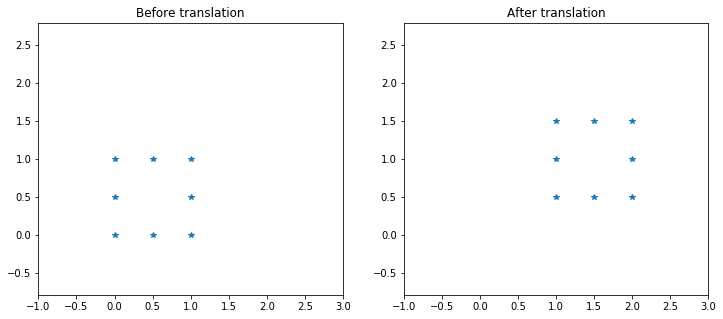

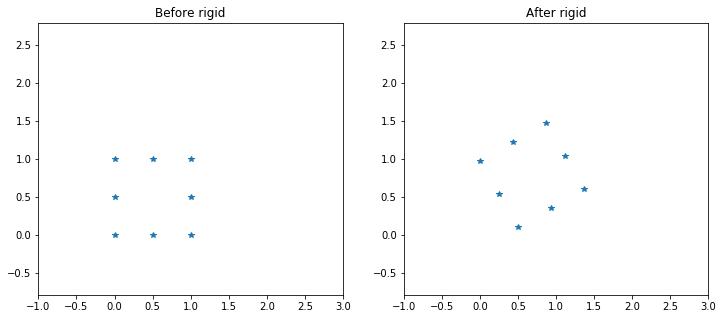

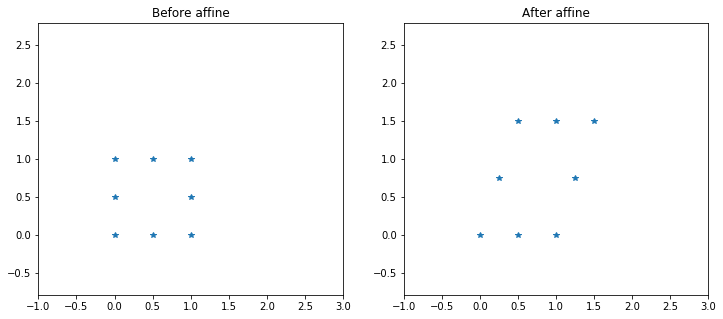

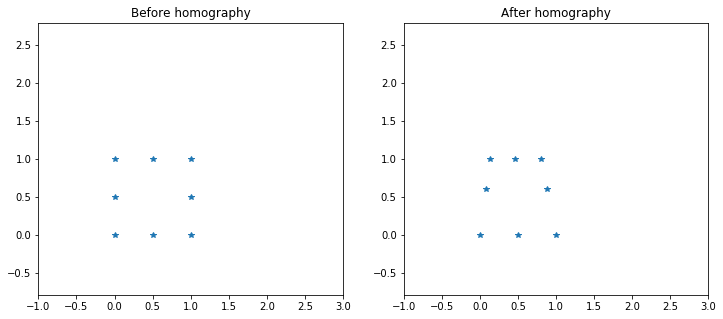

In [12]:
input_pts = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [1.0, 0.5],
                      [1.0, 1.0], [0.5, 1.0], [0.0, 1.0], [0.0, 0.5]])

cases = ['translation', 'rigid', 'affine', 'homography']
h = {}
h['translation'] = np.array([[1.0, 0.0, 1.0],
                             [0.0, 1.0, 0.5],
                             [0.0, 0.0, 1.0]])
h['rigid'] = np.array([[0.8660254, -0.5, 0.5],
                       [0.5, 0.8660254, 0.1],
                       [0.0, 0.0, 1.0]])
h['affine'] = np.array([[1.0, 0.5, 0.0],
                        [0.0, 1.5, 0.0],
                        [0.0, 0.0, 1.0]])
h['homography'] = np.array([[1.0, 0.2, 0.0],
                       [0.0, 1.5, 0.0],
                       [0.0, 0.5, 1.0]])

output_pts = {}
for c in cases:
    output_pts[c] = transform_homography(input_pts, h[c])

# Print output points and plot
for c in cases:
    print('Points after ({})\n'.format(c), output_pts[c].transpose())

    plt.figure(figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.axis('equal')
    ax.set(xlim=(-1.0, 3.0), ylim=(-1.0, 3.0))
    plt.title('Before {}'.format(c))
    plt.plot(input_pts[:, 0], input_pts[:, 1], '*')
    ax = plt.subplot(1, 2, 2)
    ax.axis('equal')
    ax.set(xlim=(-1.0, 3.0), ylim=(-1.0, 3.0))
    plt.title('After {}'.format(c))
    plt.plot(output_pts[c][:, 0], output_pts[c][:, 1], '*');

You should get the following if the function is implemented correctly:
```
Points after (translation)
 [[1.  1.5 2.  2.  2.  1.5 1.  1. ]
 [0.5 0.5 0.5 1.  1.5 1.5 1.5 1. ]]
Points after (rigid)
 [[0.5      0.933013 1.366025 1.116025 0.866025 0.433013 0.       0.25    ]
 [0.1      0.35     0.6      1.033013 1.466025 1.216025 0.966025 0.533013]]
Points after (affine)
 [[0.   0.5  1.   1.25 1.5  1.   0.5  0.25]
 [0.   0.   0.   0.75 1.5  1.5  1.5  0.75]]
Points after (homography)
 [[0.       0.5      1.       0.88     0.8      0.466667 0.133333 0.08    ]
 [0.       0.       0.       0.6      1.       1.       1.       0.6     ]]
```

### 1(b) Compute Homography Matrix

Now, implement the function to compute the homography matrix given pairs of correspondences using the *normalized* DLT algorithm.

**Implement the following function(s): `compute_homography()`**
* <u>Prohibited Functions</u>:
  `cv2.findHomography()`, `cv2.getPerspectiveTransform()`, `np.linalg.solve()`, `np.linalg.lstsq()`
* <u>You may use the following functions</u>:
  `np.linalg.svd()`

Remember to use normalization, which will increase the robustness of the estimation.

In [ ]:
# Test case with exactly 4 points
src1 = np.array([[0.0, 0.0], [331.0, 0.0], [331.0, 474.0], [0.0, 474.0]])
dst1 = np.array([[182.0, 94.0], [482.0, 48.0], [598.0, 466.0], [146.0, 533.0]])
homo1 = compute_homography(src1, dst1)

# Test case with more than 4 points
src2 = np.array([[434.375, 93.625], [429.625, 190.625], 
                 [533.625, 301.875], [452.375, 460.625], 
                 [558.375, 188.625], [342.444, 362.596], 
                 [345.625, 41.875], [341.625, 146.125]])
dst2 = np.array([[204.780, 92.367], [201.875, 190.625], 
                 [297.125, 296.875], [224.446, 456.556],
                 [318.407, 192.155], [107.625, 371.375],
                 [109.875, 26.624], [106.625, 138.125]])
homo2 = compute_homography(src2, dst2)

print('homo1:\n', homo1, '\n')
print('homo2:\n', homo2)

You should obtain approximately the following (or some scale of it) if your function is implemented correctly:

```
homo1:
 [[ 9.012217e-01 -1.792522e-01  1.820000e+02]
 [-1.394830e-01  5.490343e-01  9.400000e+01]
 [-1.062811e-05 -7.075535e-04  1.000000e+00]]
 
homo2:
 [[ 1.738142e+00  9.494425e-03 -4.466937e+02]
 [ 2.745643e-01  1.514698e+00 -1.213769e+02]
 [ 1.160079e-03  2.069049e-05  1.000000e+00]]
```

---
## Part 2: Image Warping using Homography

In this part, you will implement the image warping function. Given two images $I_{src}, I_{dst}$ and the homography matrix $\mathbf{H}$ which relates the coordinates in the two images:
$$
\mathbf{x}_{dst} = \mathbf{H}\mathbf{x}_{src}
$$,
where $\mathbf{x}_{src}$ and $\mathbf{x}_{dst}$ are pixel coordinates of $I_{src}$ and $I_{dst}$ respectively, the objective is to warp $I_{src}$ onto $I_{dst}$.

The obvious way of doing this is forward-interpolation, where for every pixel in $I_{src}$, you compute where it should be in $I_{dst}$ and copy the pixel value over. However this will result in holes in the image (why?).

The better way is to do it in the reverse direction (i.e. backward interpolation), where we compute the corresponding coordinate in $I_{src}$ for every pixel in $I_{dst}$. First create a $H_{dst}W_{dst}\times2$ matrix containing the coordinates of all the pixels in $I_{dst}$, i.e,
$$
\begin{bmatrix}
0 & 0 & 0 & \dots & W_{dst}-1 & W_{dst}-1 \\
0 & 1 & 2 & \dots & H_{dst}-2 & H_{dst}-1
\end{bmatrix}^T,
$$
where $W_{dst}$ and $H_{dst}$ are the width and height of $I_{dst}$. Then use your `transform_homography()` function to compute the corresponding coordinates in $I_{src}$. Lastly, for every pixel in the destination image, fill its value with the corresponding pixel in the source image;  you can use interpolation methods to handle non-integer soure pixel coordinates.

**Implement the following function(s): `warp_image()`**

* <u>Prohibited Functions</u>:
  `cv2.warpPerspective()`
* <u>You may use the following functions</u>:
  `cv2.remap(), np.meshgrid()`
  
If you use `cv2.remap`, you might find the `borderMode` value of `cv2.BORDER_TRANSPARENT` useful. Also consider using bilinear interpolation in `cv2.remap`.

Let us now use our functions so far to replace the book cover with another image. If all above functions are implemented correctly, you should see the book cover being replaced by another image when you run the following code.

In [ ]:
template = load_image('data/hzbook_2.jpg')
original = load_image('data/hzbook_1.jpg')
# homo is the homography matrix that maps points in template to original
homo = np.array([[ 9.01221661e-01, -1.79252179e-01, 1.82000000e+02],
                 [-1.39482959e-01,  5.49034320e-01, 9.40000000e+01],
                 [-1.06281109e-05, -7.07553504e-04, 1.00000000e+00]])
overlaid = warp_image(template, original, homo)

plt.figure()
plt.imshow(template)
plt.title('Template')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(overlaid)
plt.title('Modified image');

---
## Part 3: Robust Homography Estimation using RANSAC
In this part, we upgrade our homography estimation algorithm to be robust even in the presence of outliers. Consider the following image stitching example containing 10 provided correspondences.

In [ ]:
im1 = load_image('data/pano_2.jpg')
im2 = load_image('data/pano_3.jpg')

im1_points = np.array([[434.375, 93.625], [429.625, 190.625], 
                       [533.625, 301.875], [452.375, 460.625], 
                       [558.375, 188.625], [342.444, 362.596], 
                       [345.625, 41.875], [341.625, 146.125], 
                       [424.375, 385.375], [602.875, 183.125]])  # last row is outliers

im2_points = np.array([[204.780, 92.367], [201.875, 190.625], 
                       [297.125, 296.875], [224.446, 456.556],
                       [318.407, 192.155], [107.625, 371.375],
                       [109.875, 26.624], [106.625, 138.125],
                       [514.526, 142.354], [348.375, 304.375]])  # last row is outliers

vis = draw_matches(im1, im2, im1_points, im2_points)

plt.figure(figsize=(16, 8))
plt.imshow(vis);

Notice that 2 of the 10 correspondences are wrong. Using just the correct correspondences yields the correct result:

In [ ]:
im1_points_inliers = im1_points[:-2, :]  # exclude the last 2 wrong correspondences
im2_points_inliers = im2_points[:-2, :]
homo = compute_homography(im1_points_inliers, im2_points_inliers)

stitched = warp_images_all([im1, im2], [homo, np.eye(3)])
plt.figure(figsize=(12, 8))
plt.imshow(stitched)

print('Computed homography matrix:\n', homo)

However, if we include the two outliers, notice that the alignment fails. 

In [ ]:
homo = compute_homography(im1_points, im2_points)

stitched = warp_images_all([im2, im1], [np.eye(3), homo])
plt.figure(figsize=(12, 8))
plt.imshow(stitched);

The de-facto algorithm to solve this is RANdom SAmple Consensus (RANSAC). Your task is now to implement the robust homography computation which can handle outliers. RANSAC requires a error distance function to compute which correspondences are outliers. First, implement the symmetric transfer error distance measure as described in the lectures:

$$
d(x,x';H) = \left\lVert x - H^{-1}x' \right\rVert^2 + \left\lVert x' - Hx \right\rVert^2.
$$

**Implement the following function(s): compute_homography_error()**
* <u>Prohibited Functions</u>:
  `cv2.findHomography()`
* <u>You may use the following functions</u>:
  `np.linalg.inv()`, and `transform_homography()` from the previous sections.

In [ ]:
src = np.array([[0.0, 0.0], [1.0, 0.0], [2.0, 1.0]])
dst = np.array([[1.0, 2.0], [1.5, 2.5], [2.5, 3]])
H = np.array([[0.5, 0.0, 1.0],
              [0.0, 0.5, 2.0],
              [0.0, 0.0, 1.0]])

print('Error:', compute_homography_error(src, dst, H))

If implemented correctly, the previous code should print:

```
Error: [0.   1.25 2.5 ]
```

Now implement the RANSAC procedure covered in the lectures, using the error distance measure you just implemented:

*Be sure to re-estimate the homography transformation using all the inliers at the end of the RANSAC procedure.*

**Implement the following function(s): `compute_homography_ransac()`**

* <u>Prohibited Functions</u>:
  `cv2.findHomography()`
* <u>You may use the following functions</u>:
  `compute_homography(), compute_homography_error()` from the previous sections.

In [ ]:
homo, mask = compute_homography_ransac(im1_points, im2_points)

stitched = warp_images_all([im1, im2], [homo, np.eye(3)])

plt.figure(figsize=(12, 8))
plt.imshow(stitched)

vis = draw_matches(im1, im2, im1_points, im2_points, inlier_mask=mask)
plt.figure(figsize=(16, 8))
plt.imshow(vis)

print('Computed homography matrix:\n', homo)

If you implemented the above correctly, the above images should be aligned correctly. The RANSAC algorithm detects outliers (drawn in red) and excludes them from the homography computation. The computed homography matrix should be the same as the previous sections:
```
 [[ 1.738142e+00  9.494425e-03 -4.466937e+02]
 [ 2.745643e-01  1.514698e+00 -1.213769e+02]
 [ 1.160079e-03  2.069049e-05  1.000000e+00]]
```

At this point, we now can perform automatic alignment of the image pair. Recall in the lectures that we can detect keypoints and match them between the two images. The matches generally will contain outliers but your robust homography computation can handle those and still output the correct homography.

Let's see how our algorithm performs in such a scenario.

First, let us use OpenCV's feature detection, extraction and matching pipeline to establish potential correspondences in the two images. 

In [ ]:
# Initiate ORB detector. Detect keypoints and extracts descriptors with ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = orb.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY), None)

# Matches the descriptors via brute force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
im1_points_orb, im2_points_orb = matches2pairs(matches, kp1, kp2)

vis = draw_matches(im1, im2, im1_points_orb, im2_points_orb)
plt.figure(figsize=(16, 8))
plt.imshow(vis);

We can see that some of the correspondences are wrong. So how does our `compute_homography_ransac()` function perform?

In [ ]:
homo, mask = compute_homography_ransac(im1_points_orb, im2_points_orb)

stitched = warp_images_all([im1, im2], [homo, np.eye(3)])

plt.figure(figsize=(12, 8))
plt.imshow(stitched)

vis = draw_matches(im1, im2, im1_points_orb, im2_points_orb, inlier_mask=mask)
plt.figure(figsize=(16, 8))
plt.imshow(vis);

If implemented correctly, the images should be aligned properly, with the inliers and outliers correctly detected.

---
## Part 4: Adding more images
You are almost done! Now the last part is to extend the stitching to multiple images. To do so, suppose we have $N$ images $I_1, \dots, I_N$. We perform pairwise matching between consecutive images (i.e. $I_1 \to I_2$, $I_2 \to I_3, \dots$). We can then set one of the images (e.g. middle one) as the reference image, and warp all the homographies to it.

Implement the function that computes the homography warping matrices for each image from pairwise homography matrices. Specifically, given $\mathbf{H}_1^2, \mathbf{H}_2^3, \dots, \mathbf{H}_{N-1}^N$ which represents the homography matrices between consecutive images:
$$
\mathbf{x}_{k+1} = \mathbf{H}_{k}^{k+1} \mathbf{x}_{k},
$$
compute the absolute homography matrices $\mathbf{H}_1^{ref}, \mathbf{H}_2^{ref}, \dots, \mathbf{H}_{N-1}^{ref}$ that can be used to warp all images to the reference image:

**Implement the following function(s): `concatenate_homographies()`**

In [ ]:
# Initiate ORB detector. Detect keypoints and extracts descriptors for all images.
orb = cv2.ORB_create()
num_images = 4
all_im, all_kp, all_des = [], [], []
for i in range(num_images):
    im = load_image('data/pano_{}.jpg'.format(i))
    kp, des = orb.detectAndCompute(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), None)
    all_im.append(im)
    all_kp.append(kp)
    all_des.append(des)
    
# Matches the descriptors between consecutive images via brute force matching, and
# computes the homography matrices.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
pairwise_homographies = []
for i in range(num_images-1):
    matches = bf.match(all_des[i], all_des[i+1])
    im1_points_orb, im2_points_orb = matches2pairs(matches, all_kp[i], all_kp[i+1])
    h_i1_i, mask = compute_homography_ransac(im1_points_orb, im2_points_orb)
    pairwise_homographies.append(h_i1_i)

In [ ]:
all_h_matrices = concatenate_homographies(pairwise_homographies, ref=2)

stitched = warp_images_all(all_im, all_h_matrices)
plt.figure(figsize=(16, 8))
plt.imshow(stitched);

If you implemented `concatenate_homographies()` correctly, you should get a coherent panorama. Congratulations! You have reached the end of the first assignment.